Copyright 2021 The TensorFlow Similarity Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
from collections import defaultdict
import gc
import os

import matplotlib.pyplot as plt
import numpy as np

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD

In [4]:
# install TF similarity if needed
try:
    import tensorflow_similarity as tfsim  # main package
except:
    !pip install tensorflow_similarity
    import tensorflow_similarity as tfsim

Your CPU supports instructions that this binary was not compiled to use: SSE3 SSE4.1 SSE4.2 AVX AVX2
For maximum performance, you can install NMSLIB from sources 
pip install --no-binary :all: nmslib


In [5]:
from tensorflow_similarity.samplers import SingleShotMemorySampler
from tensorflow_similarity.augmenters import SimCLRAugmenter
from tensorflow_similarity.models import ContrastiveModel
from tensorflow_similarity.losses import SimSiamLoss
from tensorflow_similarity.losses import SimCLRLoss
from tensorflow_similarity.training_metrics import encoder_std  ## siam siam metric
from tensorflow_similarity.visualization import visualize_views

In [6]:
tfsim.utils.tf_cap_memory() # Avoid GPU memory blow up

2021-10-24 20:32:11.239276: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-24 20:32:11.248538: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-24 20:32:11.249162: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [7]:
tf.keras.backend.clear_session() 
gc.collect()

0

# Dataset

## Loading

In [8]:
(x_train, y_raw_train), (x_test, y_raw_test) = keras.datasets.cifar10.load_data()
print("x_train", x_train.shape, "x_test", x_test.shape)
y_train = keras.utils.to_categorical(y_raw_train, 10)
y_test = keras.utils.to_categorical(y_raw_test, 10)
print("y_train", y_train.shape, "y_test", y_test.shape)

x_train (50000, 32, 32, 3) x_test (10000, 32, 32, 3)
y_train (50000, 10) y_test (10000, 10)


In [9]:
IMG_SIZE = 32
BATCH_SIZE = 128

# LR = 0.05
# INIT_LR = LR * BATCH_SIZE / 256.0
INIT_LR = 0.03
PRE_TRAIN_EPOCHS = 200
STEPS_PER_EPOCH = len(x_train) // BATCH_SIZE

WEIGHT_DECAY = 0.0005

In [10]:
train_augmenter = SimCLRAugmenter(IMG_SIZE, IMG_SIZE, is_training=True)
sampler = SingleShotMemorySampler(x_train, examples_per_batch=BATCH_SIZE, steps_per_epoch=STEPS_PER_EPOCH, augmenter=train_augmenter, num_augmentations_per_example=2)


The initial batch size is 128 (128 classes * 1 examples per class) with 2 augmenters


2021-10-24 20:32:12.120395: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-24 20:32:12.121683: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-24 20:32:12.122701: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-24 20:32:12.123362: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

2021-10-24 20:32:14.210169: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


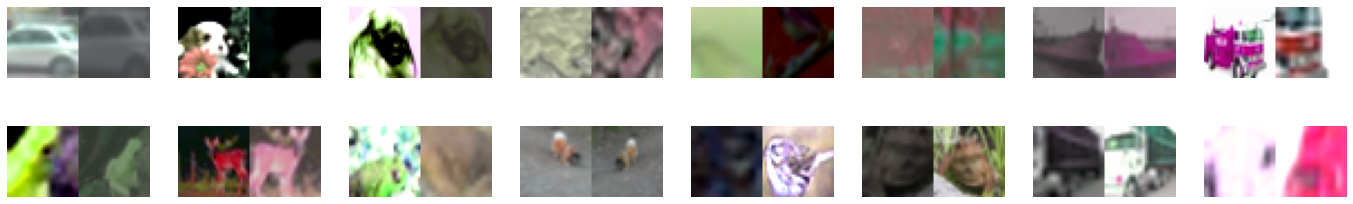

In [11]:
views = sampler.generate_batch(0)

visualize_views(views=views, num_imgs=16, views_per_col=8)

# Models

## Backbone 

In [12]:
!wget -q https://git.io/JYx2x -O resnet_cifar10_v2.py

In [13]:
import resnet_cifar10_v2

N = 2
DEPTH = N * 9 + 2
NUM_BLOCKS = ((DEPTH - 2) // 9) - 1

In [14]:
def get_encoder(img_size, dim=2048, activation='relu', trainable=True):
#     base_model = tf.keras.applications.ResNet50V2(include_top=False,
#         weights=None, input_shape=(img_size, img_size, 3))
#     base_model.trainable = trainable

    inputs = layers.Input((img_size, img_size, 3))
    # ResNet expects [-1,1], but our augmented images are [0,1]
    x = layers.Rescaling(scale=2, offset=-1)(inputs)
    x = resnet_cifar10_v2.stem(x)
    x = resnet_cifar10_v2.learner(x, NUM_BLOCKS)
    # x = base_model(x, training=trainable)
    x = layers.GlobalAveragePooling2D(name="backbone_pool")(x)
    
    # Projection Head
    x = layers.Dense(dim, activation=activation, use_bias=False, kernel_regularizer=regularizers.l2(WEIGHT_DECAY))(x)
    x = layers.BatchNormalization()(x)
    
#     x = layers.Dense(dim, activation=activation, use_bias=False, kernel_regularizer=regularizers.l2(WEIGHT_DECAY))(x)
#     x = layers.BatchNormalization()(x)
    
    x = layers.Dense(dim, use_bias=False, kernel_regularizer=regularizers.l2(WEIGHT_DECAY))(x)
    o = layers.BatchNormalization()(x)

    backbone = Model(inputs, o, name='encoder')
    return backbone

simsiam_encoder = get_encoder(IMG_SIZE)
simsiam_encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 32, 32, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_166 (Conv2D)             (None, 32, 32, 16)   432         rescaling[0][0]                  
__________________________________________________________________________________________________
batch_normalization_164 (BatchN (None, 32, 32, 16)   64          conv2d_166[0][0]                 
____________________________________________________________________________________________

## Predictor model

In [15]:
def get_predictor(dim, hiddin_dim=512, activation='relu'):
    inputs = layers.Input(shape=(dim,))
    
    x = layers.Dense(hiddin_dim, activation=activation, use_bias=False, kernel_regularizer=regularizers.l2(WEIGHT_DECAY))(inputs)
    x = layers.BatchNormalization()(x)
    
    o = layers.Dense(dim)(x)
    projector = Model(inputs, o, name="predictor")
    return projector

simsiam_predictor = get_predictor(2048)
simsiam_predictor.summary()

Model: "predictor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 2048)]            0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               1048576   
_________________________________________________________________
batch_normalization_185 (Bat (None, 512)               2048      
_________________________________________________________________
dense_4 (Dense)              (None, 2048)              1050624   
Total params: 2,101,248
Trainable params: 2,100,224
Non-trainable params: 1,024
_________________________________________________________________


# Loss

In [16]:
# This loss is minimizing either the cosine distance or the angular 
# distance and should be between [0, 4]
loss = SimSiamLoss(loss_type='angular_distance')
metrics = [[encoder_std], []]

# Pre Training

In [17]:
contrastive_model = ContrastiveModel(
    encoder_model=simsiam_encoder, 
    projector_model=simsiam_predictor, 
    swap_representation=True)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="loss", patience=5, restore_best_weights=True
)
# use sgd as optimizer with constant loss as recommende in the paper.
lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=INIT_LR, decay_steps=PRE_TRAIN_EPOCHS * STEPS_PER_EPOCH
)
sgd = tf.keras.optimizers.SGD(lr_decayed_fn, momentum=0.6)
contrastive_model.compile(optimizer=sgd, loss=loss, metrics=metrics)

In [ ]:
contrastive_history = contrastive_model.fit(sampler, epochs=PRE_TRAIN_EPOCHS, callbacks=[early_stopping])

Epoch 1/200


2021-10-24 20:32:25.456911: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


390/390 [==============================] - 114s 276ms/step - loss: 0.1597 - output_1_encoder_std: 0.0221
Warmup complete
Epoch 2/200
390/390 [==============================] - 108s 273ms/step - loss: 0.1420 - output_1_encoder_std: 0.0221
Epoch 3/200
390/390 [==============================] - 106s 271ms/step - loss: 0.1379 - output_1_encoder_std: 0.0221
Epoch 4/200
390/390 [==============================] - 106s 270ms/step - loss: 0.1356 - output_1_encoder_std: 0.0221
Epoch 5/200
390/390 [==============================] - 106s 270ms/step - loss: 0.1336 - output_1_encoder_std: 0.0221
Epoch 6/200
390/390 [==============================] - 106s 271ms/step - loss: 0.1326 - output_1_encoder_std: 0.0221
Epoch 7/200
390/390 [==============================] - 105s 269ms/step - loss: 0.1312 - output_1_encoder_std: 0.0221
Epoch 8/200
390/390 [==============================] - 105s 269ms/step - loss: 0.1302 - output_1_encoder_std: 0.0221
Epoch 9/200
390/390 [==============================] - 105s 

In [ ]:
plt.plot(contrastive_history.history['loss'])
plt.grid("Angular Distance")
plt.show()

# Distances after 5 epochs

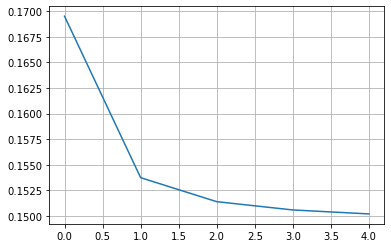

In [19]:
plt.plot(contrastive_history.history['loss'])
plt.grid("Angular Distance")
plt.show()

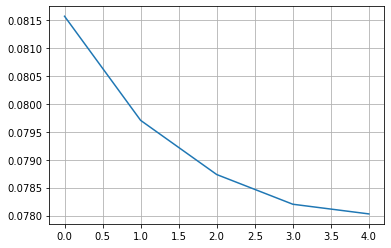

In [29]:
plt.plot(contrastive_history.history['loss'])
plt.grid("Cosine Distance")
plt.show()

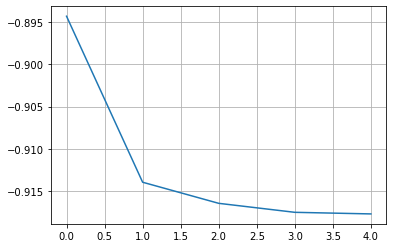

In [25]:
plt.plot(contrastive_history.history['loss'])
plt.grid("Negative Cosine Similairty")
plt.show()

# Evaluation

In [27]:
from tensorflow_similarity.samplers import select_examples

# allows to use a fraction of the dataset via select_sample
x_restricted, y_restricted = select_examples(x_train, y_raw_train, num_examples_per_class=100)
y_restricted = keras.utils.to_categorical(y_restricted, 10)

TEST_EPOCHS = 20
TEST_STEPS_PER_EPOCH = len(x_restricted) // BATCH_SIZE

filtering examples:   0%|          | 0/50000 [00:00<?, ?it/s]

selecting classes:   0%|          | 0/10 [00:00<?, ?it/s]

gather examples:   0%|          | 0/1000 [00:00<?, ?it/s]

In [28]:
def get_eval_model(img_size, encoder):
    encoder.trainable = False
    inputs = layers.Input((img_size, img_size, 3))
    x = encoder(inputs, training=False)
    o = layers.Dense(10, activation='softmax')(x)
    model = Model(inputs, o, name='no_pretrain')
    model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['acc'])
    return model

# No pretrain

In [29]:
no_pt_encoder = get_encoder(IMG_SIZE)
no_pt_encoder = Model(
    no_pt_encoder.input, no_pt_encoder.get_layer("backbone_pool").output
)
reg_model = get_eval_model(IMG_SIZE, no_pt_encoder)
reg_history = reg_model.fit(x_restricted, y_restricted, batch_size=BATCH_SIZE, epochs=TEST_EPOCHS, validation_data=(x_test, y_test))

Epoch 1/20
8/8 [==============================] - 3s 182ms/step - loss: 37.2879 - acc: 0.0720 - val_loss: 17.2530 - val_acc: 0.0948
Epoch 2/20
8/8 [==============================] - 1s 79ms/step - loss: 15.0370 - acc: 0.0900 - val_loss: 14.3401 - val_acc: 0.0942
Epoch 3/20
8/8 [==============================] - 1s 78ms/step - loss: 12.2466 - acc: 0.1200 - val_loss: 8.4830 - val_acc: 0.1281
Epoch 4/20
8/8 [==============================] - 1s 79ms/step - loss: 8.5875 - acc: 0.1300 - val_loss: 7.5121 - val_acc: 0.1277
Epoch 5/20
8/8 [==============================] - 1s 81ms/step - loss: 7.1318 - acc: 0.1290 - val_loss: 6.8465 - val_acc: 0.1456
Epoch 6/20
8/8 [==============================] - 1s 77ms/step - loss: 6.4582 - acc: 0.1630 - val_loss: 6.1746 - val_acc: 0.1556
Epoch 7/20
8/8 [==============================] - 1s 78ms/step - loss: 5.8594 - acc: 0.1730 - val_loss: 5.8264 - val_acc: 0.1766
Epoch 8/20
8/8 [==============================] - 1s 78ms/step - loss: 5.5673 - acc: 0.1810

# Pretrained with SiamSiam

In [30]:
contrastive_model.projector.summary()

Model: "predictor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 2048)]            0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               1048576   
_________________________________________________________________
batch_normalization_185 (Bat (None, 512)               2048      
_________________________________________________________________
dense_4 (Dense)              (None, 2048)              1050624   
Total params: 2,101,248
Trainable params: 2,100,224
Non-trainable params: 1,024
_________________________________________________________________


In [31]:
# Extract the backbone ResNet20.
pt_encoder = Model(
    contrastive_model.get_encoder().input, contrastive_model.get_encoder().get_layer("backbone_pool").output
)
model2 = get_eval_model(IMG_SIZE, pt_encoder)
model2.summary()

Model: "no_pretrain"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
model_5 (Functional)         (None, 256)               568368    
_________________________________________________________________
dense_16 (Dense)             (None, 10)                2570      
Total params: 570,938
Trainable params: 2,570
Non-trainable params: 568,368
_________________________________________________________________


In [32]:
pre_history = model2.fit(x_restricted, y_restricted, batch_size=BATCH_SIZE, epochs=TEST_EPOCHS, validation_data=(x_test, y_test))

Epoch 1/20
8/8 [==============================] - 3s 169ms/step - loss: 36.8190 - acc: 0.1030 - val_loss: 21.5085 - val_acc: 0.1245
Epoch 2/20
8/8 [==============================] - 1s 82ms/step - loss: 16.5482 - acc: 0.1310 - val_loss: 13.3824 - val_acc: 0.1084
Epoch 3/20
8/8 [==============================] - 1s 79ms/step - loss: 11.5886 - acc: 0.1240 - val_loss: 9.9409 - val_acc: 0.1097
Epoch 4/20
8/8 [==============================] - 1s 81ms/step - loss: 9.3468 - acc: 0.1150 - val_loss: 7.8064 - val_acc: 0.1182
Epoch 5/20
8/8 [==============================] - 1s 81ms/step - loss: 8.3148 - acc: 0.1430 - val_loss: 8.5327 - val_acc: 0.1655
Epoch 6/20
8/8 [==============================] - 1s 79ms/step - loss: 7.4539 - acc: 0.1350 - val_loss: 6.8505 - val_acc: 0.1421
Epoch 7/20
8/8 [==============================] - 1s 79ms/step - loss: 6.4605 - acc: 0.1440 - val_loss: 6.4512 - val_acc: 0.1351
Epoch 8/20
8/8 [==============================] - 1s 79ms/step - loss: 6.0407 - acc: 0.1300

In [33]:
print('no pretrain', reg_model.evaluate(x_test, y_test))
print('pretrained', model2.evaluate(x_test, y_test))

313/313 [==============================] - 2s 5ms/step - loss: 4.4177 - acc: 0.1910
no pretrain [4.41769552230835, 0.19099999964237213]
313/313 [==============================] - 2s 5ms/step - loss: 5.2988 - acc: 0.1921
pretrained [5.298776626586914, 0.19210000336170197]
